In [1]:
!pwd

/home/nicolasf/operational/OISST_indices/notebooks


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline
import cmocean
from matplotlib import pyplot as plt

In [4]:
import os
import pathlib
import sys
from subprocess import call

In [5]:
from datetime import datetime, timedelta

In [6]:
import numpy as np
import pandas as pd
import xarray as xr
import dask
from dask.diagnostics import ProgressBar

In [7]:
sys.path.append("../code/")

In [8]:
import src

### parameters for papermill 

In [9]:
domain = "NZ"
ipath = "/media/nicolasf/END19101/data/OISST/daily"
clim_path = "/home/nicolasf/operational/OISST_indices/outputs/"
fig_path = "/home/nicolasf/operational/OISST_indices/figures/"
ndays_agg = 1
quantile = .9
lag = 0

### get the pathlib paths for the data and the climatology 

In [10]:
ipath = pathlib.Path(ipath).joinpath(domain)
clim_path = pathlib.Path(clim_path).joinpath(domain)
fig_path = pathlib.Path(fig_path)

### get the current date 

In [11]:
current_date = datetime.utcnow()

## get the years to read 

In [12]:
years_to_get = np.unique(np.arange(1982, current_date.year + 1))

In [13]:
lfiles = [ipath.joinpath(f"sst.day.mean.{year}.v2.nc") for year in years_to_get]

In [14]:
lfiles.sort()

In [15]:
lfiles[0]

PosixPath('/media/nicolasf/END19101/data/OISST/daily/NZ/sst.day.mean.1982.v2.nc')

In [16]:
lfiles[-1]

PosixPath('/media/nicolasf/END19101/data/OISST/daily/NZ/sst.day.mean.2022.v2.nc')

## opens the near realtime dataset 

In [17]:
dset = xr.open_mfdataset(lfiles, parallel=True, combine="by_coords")

In [18]:
dset

<xarray.Dataset>
Dimensions:  (time: 14846, lon: 72, lat: 80)
Coordinates:
  * time     (time) datetime64[ns] 1982-01-01 1982-01-02 ... 2022-08-24
  * lon      (lon) float32 162.1 162.4 162.6 162.9 ... 179.1 179.4 179.6 179.9
  * lat      (lat) float32 -49.88 -49.62 -49.38 -49.12 ... -30.62 -30.38 -30.12
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(365, 80, 72), meta=np.ndarray>

### calculates the rolling averages here if the number of days > 1

In [19]:
if ndays_agg > 1:

    dset = dset.rolling({"time": ndays_agg}, min_periods=ndays_agg, center=False).mean(
        "time"
    )

    dset = dset.isel(time=slice(ndays_agg + 1, None))

### first and last day in the dataset 

In [20]:
first_day = pd.to_datetime(dset.time.data[0])
last_day = pd.to_datetime(dset.time.data[-1])

In [21]:
standard_calendar = xr.date_range(start=first_day, end=last_day)

/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/xarray/coding/cftime_offsets.py:1130: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  return pd.date_range(


### get rid of the 29th of Feb if present 

In [22]:
dset = dset.convert_calendar("noleap")

### opens the climatology 

In [23]:
clim = xr.open_zarr(
    clim_path.joinpath(f"{domain}_OISST_{ndays_agg}days_climatology_15_window.zarr")
)

In [24]:
clim = clim[['quantiles']]

In [25]:
clim = clim.chunk({'dayofyear':-1, 'quantile':-1, 'lat':2, 'lon':2})

### repeat the climatology over the time dimension 

In [26]:
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    clim_repeat = clim.sel(dayofyear=dset.time.dt.dayofyear)

In [27]:
clim_repeat

,Array,Chunk
Bytes,4.46 GiB,90.34 kiB
Shape,"(14836, 7, 80, 72)","(413, 7, 2, 2)"
Count,54857 Tasks,51840 Chunks
Type,float64,numpy.ndarray


### derive the mask highlighting MHW conditions

In [28]:
mask = dset["sst"].where(dset["sst"] >= clim_repeat["quantiles"].sel(quantile=quantile))

In [29]:
mask = mask.where(np.isnan(mask), other=1)

In [30]:
mask = mask.interp_calendar(standard_calendar)

### chunks 

In [31]:
mask_to_detect = mask.chunk(dict(time=-1, lat=1, lon=1))

### get the index 

In [32]:
index = mask_to_detect['time'].to_index()

### interpolate the NaN values for sequences shorter than max_gap

In [33]:
max_gap = 5

In [34]:
with dask.config.set(**{'array.slicing.split_large_chunks': True}):

    mask_to_detect = mask_to_detect.interpolate_na(use_coordinate=True, dim='time', max_gap=f'{max_gap}D', method='nearest')

/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/dask/array/core.py:4571: PerformanceWarning: Increasing number of chunks by factor of 72
  result = blockwise(


In [35]:
mask_to_detect = mask_to_detect.stack(z=('lat','lon'))

In [36]:
mask_to_detect = mask_to_detect.dropna('z', how='all')

/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/dask/array/reductions.py:567: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/dask/array/reductions.py:567: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/dask/array/reductions.py:567: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/dask/array/reductions.py:567: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/dask/array/reductions.py:567: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/home

In [37]:
mask_to_detect = mask_to_detect.fillna(0)

In [38]:
def detect_MWH(data): 
    
    import numpy as np
    from scipy import ndimage
    
    data_zeroes = np.zeros_like(data)
    
    events, n_events = ndimage.label(data)
    
    istarts = []
    durations = []

    for ev in range(1, n_events+1):

        durations.append((events == ev).sum()) 
        istarts.append(np.where(events == ev)[0][0])
        
    data_zeroes[istarts] = durations
    
    return data_zeroes, events

In [39]:
starts_and_durations, events = np.apply_along_axis(detect_MWH, 0, mask_to_detect.data)

In [ ]:
with ProgressBar(): 
    starts_and_durations = starts_and_durations.compute()
    events = events.compute()

In [41]:
starts_and_durations.shape

(14846, 5331)

In [42]:
events.shape

(14846, 5331)

In [49]:
mask_to_detect['mhw'] = (('time','z'), starts_and_durations)

In [51]:
mask_to_detect = mask_to_detect.unstack()

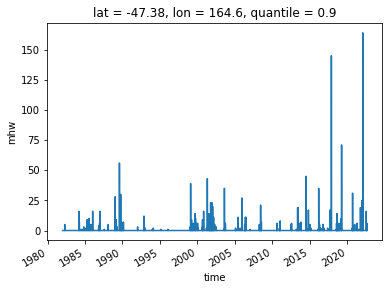

In [52]:
mask_to_detect['mhw'].isel(lat=10, lon=10).plot()

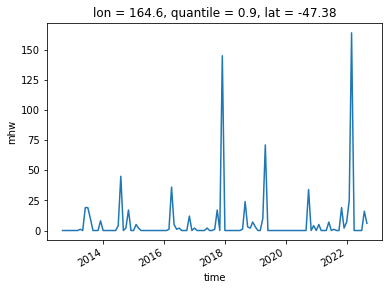

In [53]:
mask_to_detect['mhw'].isel(lat=10, lon=10, time=slice(-365*10, None)).resample(dict(time='1M')).sum().plot()

In [54]:
MHWs = mask_to_detect['mhw']

In [55]:
MHWs = MHWs.drop('mhw')

In [56]:
MHWs = MHWs.to_dataset()

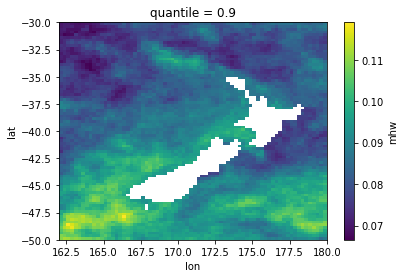

In [57]:
MHWs.mean('time')['mhw'].plot()

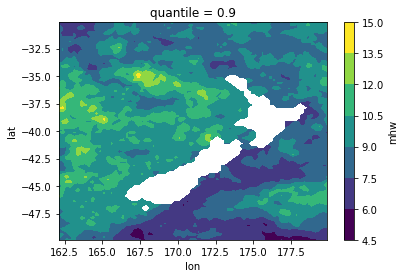

In [65]:
MHWs.where(MHWs['mhw']>0).mean('time')['mhw'].plot.contourf(levels=10)